# Modelos Epidemiológicos COVID-19

## Introdução
Aqui vamos avaliar diferentes modelos epidemiológicos para tentarmos entender os possíveis caminhos que a COVID-19 pode tomar no Brasil. Apesar de alguns sistemas de equações diferenciais usados aqui terem solução analítica, usaremos sempre um resolvedor numérico.

## Crescimento exponencial
No começo de uma epidemia, é comum vermos crescimento exponencial do número de casos. Por exemplo, aqui está a progressão de casos de COVID-19 no Brasil entre 26/02/2020 e 24/03/2020:

| Data | Casos | Data | Casos | Data | Casos | Data | Casos|
|-|-:|-|-:|-|-:|-|-:|
| 26/02 | 1 | 04/03 | 3  | 11/03 | 52  | 18/03 | 529  |
| 27/02 | 1 | 05/03 | 8  | 12/03 | 77  | 19/03 | 647  |
| 28/02 | 1 | 06/03 | 13 | 13/03 | 98  | 20/03 | 977  |
| 29/02 | 2 | 07/03 | 25 | 14/03 | 98  | 21/03 | 1226 |
| 01/03 | 2 | 08/03 | 25 | 15/03 | 98  | 22/03 | 1604 |
| 02/03 | 2 | 09/03 | 25 | 16/03 | 234 | 23/03 | 1960 |
| 03/03 | 2 | 10/03 | 34 | 17/03 | 349 | 24/03 | 2271 |

Usando a variável $I$ (e $I_d$ para o número de infectados num determinado dia) para denotar o número de infectados, nós observamos um crescimento médio de 33.13% ao dia. Podemos modelar esse comportamento de forma _discreta_ (no sentido matemático) estimando que

$$I_{d+1} = 1.3313 I_d$$

Ou de maneira _contínua_ usando a equação diferencial

$$I'(t) = 0.3313I,$$

Onde o símbolo $'$ significa a _derivada_ de $I$. Colocando o primeiro modelo num gráfico, temos:

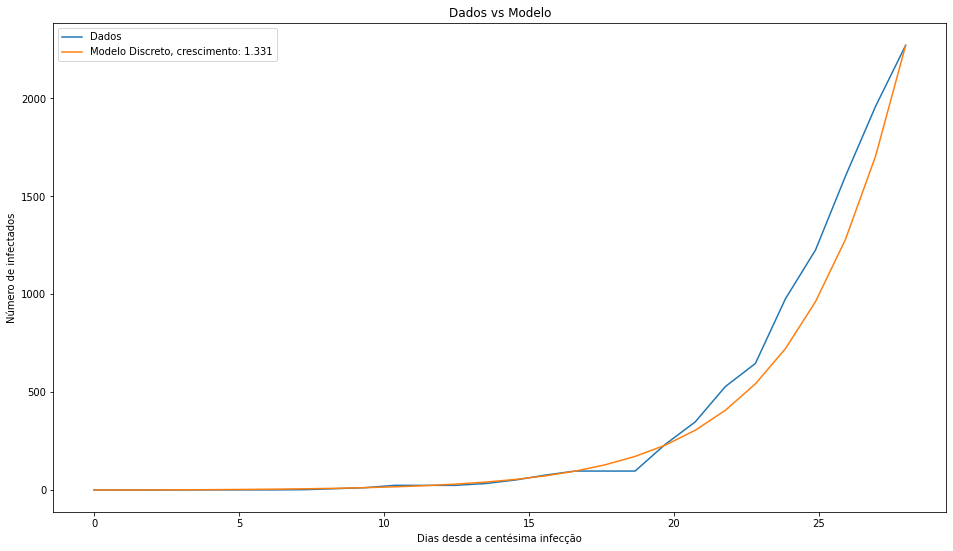

In [1]:
from ipywidgets import interactive, fixed
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

dados = [1, 1, 1, 2, 2, 2, 2, 3, 8, 13, 25, 25, 25, 34, 52, 77, 
         98, 98, 98, 234, 349, 529, 647, 977, 1226, 1604, 1960, 2271]
taxa_media = (dados[-1]/dados[0])**(1/(len(dados)-1))
modelo_discreto = [dados[0] * taxa_media**n for n in range(len(dados))]
t = np.linspace(0, len(dados), len(dados))
fig,ax = plt.subplots()
dados_plot = ax.plot(t, dados, label='Dados')
discreto_plot = ax.plot(t, modelo_discreto, label=f'Modelo Discreto, crescimento: {taxa_media:.4}')
ax.set_xlabel('Dias desde a centésima infecção')
ax.set_ylabel('Número de infectados')
ax.set_title('Dados vs Modelo')
l = ax.legend()

## Modelo SIR
O modelo mais usado para modelar epidemias é o SIR. Nele, presume-se que as pessoas podem passar por três estágios: Suscetível, Infeccioso e Resolvido. Por enquanto, esse modelo parece apropriado para essa epidemia, já que a hipótese de uma reinfecção parece remota.

<p align="center">
  <img src="SIR.png">
</p>

### Premissas do modelo SIR

Vamos usar as letras $S$ para suscetível, $I$ para infeccioso e $R$ para Resolvido e $N$ para a população inicial total, ou seja, a soma $S+I+R$. O modelo presume que cada população começa com um determinado valor e tenta prever a evolução futura delas. Para isso, ele define as taxas de variação de cada uma das funções. O número de suscetíveis que se torna infectado é dado por $\beta I\frac{S}{N}$, onde $\beta$ é quantos novos casos por dia são causados por cada infectado, em média; $S/N$ é a fração de suscetíveis sobre a população total. Já a mudança nas resoluções (curas ou mortes) é dado por $I/\mu$, onde $\mu$ é a média de dias até a resolução. Assim, temos:

$$
\begin{align}
  S'(t) & = -\beta I\frac{S}{N}\\
  I'(t) & = \beta I\frac{S}{N} - \frac{I}{\mu}\\
  R'(t) & = \frac{I}{\mu}
\end{align}
$$

Uma medida que foi bastante falada na mídia desde o início dessa pandemia é o _número básico de reprodução_, normalmente denotado por $R_0$ (sem relação com o $R$ acima). Nesse modelo, o número é dado por $\beta\mu$, ou seja, o número médio de novas infecções a cada dia por infectado, multiplicado pelo número médio de dias de infecção.

In [4]:
from scipy import integrate

def solve_sir(S_i=210_000_000., I_i=2200., R_i=100., beta=0.16, mu=14, dias=365, N=24):
    """Plot a solution to the SIR differential equations."""
    
    def sir_deriv(s_i_r, t0, beta=beta, mu=mu):
        """Compute the time-derivative of a Lorenz system."""
        s, i, r = s_i_r
        n = s + i + r
        return [
            -beta * i * s/n, 
            beta * i * s/n - i/mu, 
            i/mu
        ]
    
    t = np.linspace(0,dias,int(N*dias))
    s_i_r_t = integrate.odeint(sir_deriv, (S_i, I_i, R_i), t)
    plt.plot(t, s_i_r_t)
    plt.show()
    print("R_0 = "+str(beta*mu))
    return t, s_i_r_t

w=interactive(solve_sir, S_i=fixed(210_000_000), I_i=fixed(2200), R_i=fixed(100), 
              beta=(0.0, 0.5, 0.01), mu=(1,30), N=fixed(10))
w

interactive(children=(FloatSlider(value=0.16, description='beta', max=0.5, step=0.01), IntSlider(value=14, des…

In [3]:
result = w.result[1]
demanda_uti = int(max(result[:,1])*.05)
print(f'Máximo de casos graves simultâneos: {demanda_uti:,}')
resolvidos = result[-1][-1]
mortes_estimadas = int(resolvidos * .01)
print(f'Mortes estimadas indepedente de UTI: {mortes_estimadas:,}')
print(f'Pessoas ainda suscetíveis ao final: {int(result[-1][0]):,}')

Máximo de casos graves simultâneos: 2,032,212
Mortes estimadas indepedente de UTI: 1,788,239
Pessoas ainda suscetíveis ao final: 31,176,777


## Simulações